In [59]:
import matplotlib.pyplot as plt
from qpac.kernel import *
from qpac.funct import *
from qpac.kQEq import kernel_qeq
from qpac.descriptors import dscribeSOAP

from ase.units import Hartree
from ase.io import read, write

import numpy as np

In [60]:
ZnOall = read("ZnObulk.xyz@:",format="extxyz")

In [61]:
ZnO2all = read("ZnO2bulk.xyz@:",format="extxyz")

In [62]:
ZnOwhole = ZnOall[:336]
ZnOvac = ZnOall[336:]

In [63]:
ZnO2whole = ZnO2all[:189]
ZnO2vac = ZnO2all[189:]

In [64]:
random.seed(20)
random.shuffle(ZnOwhole)
random.shuffle(ZnOvac)
random.shuffle(ZnO2whole)
random.shuffle(ZnO2vac)

In [65]:
print(len(ZnOwhole))
print(len(ZnOvac))
print(len(ZnO2whole))
print(len(ZnO2vac))

336
320
189
180


Following cell contains original code for the training from the paper. However, training would take longer. 

In [66]:
# train_set = ZnOwhole[:150]
# train_set.extend(ZnO2whole[:80])
# train_set.extend(ZnOvac[:150])
# train_set.extend(ZnO2vac[:80])

# test_set = ZnOwhole[150:]
# test_set.extend(ZnO2whole[80:])
# test_set.extend(ZnOvac[150:])
# test_set.extend(ZnO2vac[80:])


In [67]:
train_set = ZnOwhole[:5]
train_set.extend(ZnO2whole[:5])
train_set.extend(ZnOvac[:5])
train_set.extend(ZnO2vac[:5])

test_set = ZnOwhole[5:10]
test_set.extend(ZnO2whole[5:10])
test_set.extend(ZnOvac[5:10])
test_set.extend(ZnO2vac[5:10])


In [68]:
atom_energy = {"Zn": -49117.02929728, "O": -2041.3604}
hard_lib = {"O": 1*Hartree, "Zn": 1*Hartree}


species = np.unique([spec  for mol in train_set for spec in  mol.get_chemical_symbols()])

In [69]:

SOAPclass = dscribeSOAP(nmax = 6,
                   lmax =5 ,
                    rcut = 3.0,
                    sigma = 3.0/8,
                    species = ["Zn","O"],
                    periodic = True)

SOAP_Kernel = SOAPKernel(multi_SOAP=False,
                         Descriptor=SOAPclass, 
                         training_set=train_set,
                         training_system_charges=[0 for a in train_set],
                         sparse=True,
                         sparse_count=1000,
                         perEl = False,
                         sparse_method = "CUR")
# SOAP_Kernel = SOAPKernel(multi_SOAP=False,
#                          descriptor_dict=desdictSOAP,
#                          perEl = False,
#                          sparse=True)


In [70]:
# Energy of the training set
ref_en_train = get_energies(mols=train_set,atom_energy = atom_energy)

# # Create an instance of the kQEq class

my_kqeq = kernel_qeq(Kernel=SOAP_Kernel,
                     scale_atsize=1.0/np.sqrt(2),
                     radius_type="qeq",
                     hard_lib = hard_lib,
                    periodic=True)

In [71]:
# my_kqeq.load_kQEq(nameW="weightsNewZnO2.npy",nameS="sparseSOAPNewZnO2.npy")
my_kqeq.trainEnCharge(atom_energy=atom_energy,
                      charge_keyword="hirshfeld", 
                      lambda_reg = 0.01,
                      lambda_charges=  0.1,
                      lambda_charges_min=0.01,
                      max_iter = 100,
                      iter_charges = 2)
# if the system is pretrained, comment trainEnCharge function and uncomment loading functon
#my_kqeq.load_kQEq()

####################################################################
New RMSE: 20.58018655923909
Old RMSE: 10000
Bad RMSEs in row: 1
Sample of charges: [-0.47163434 -0.47159563 -0.50475226 -0.50585511 -0.50499226 -0.50467451
 -0.51924753 -0.51926308 -0.24742305 -0.24737857]
iteration 0 is done
####################################################################
####################################################################
New RMSE: 2.044612381075839
Old RMSE: 20.58018655923909
Bad RMSEs in row: 1
Sample of charges: [-0.40449187 -0.40448397 -0.40182534 -0.40254653 -0.40194365 -0.40170738
 -0.41550317 -0.41551036 -0.26725891 -0.2670243 ]
iteration 1 is done
####################################################################
####################################################################
New RMSE: 0.036861574775219584
Old RMSE: 2.044612381075839
Bad RMSEs in row: 1
Sample of charges: [-0.40273252 -0.40273406 -0.38843401 -0.38907453 -0.38851918 -0.38829712
 -0.40078447 -0.4007

In [72]:
my_kqeq.save_kQEq()

In [73]:
E_train = []
q_train = []
for a in train_set:
    res = my_kqeq.calculateEQ(a)
    E_train.append(res["energy"]/len(a))
    q_train.extend(res["charges"])
ref_en_train = get_energies_perAtom(mols=train_set,atom_energy = atom_energy)
ref_q_train = get_charges(train_set,charge_keyword = "hirshfeld")

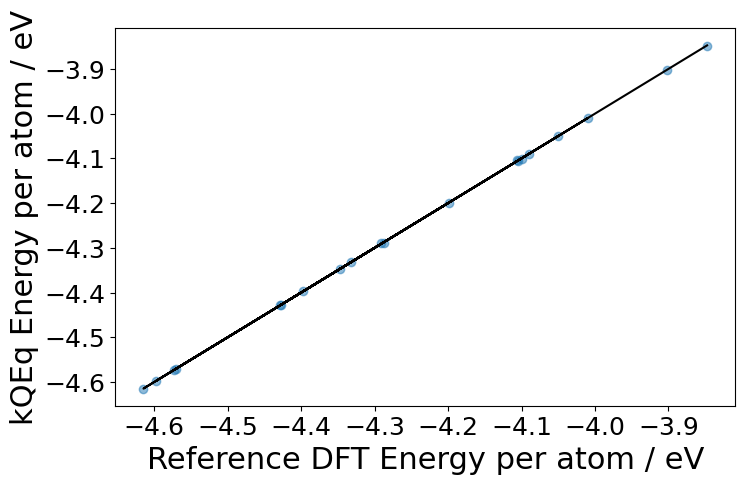

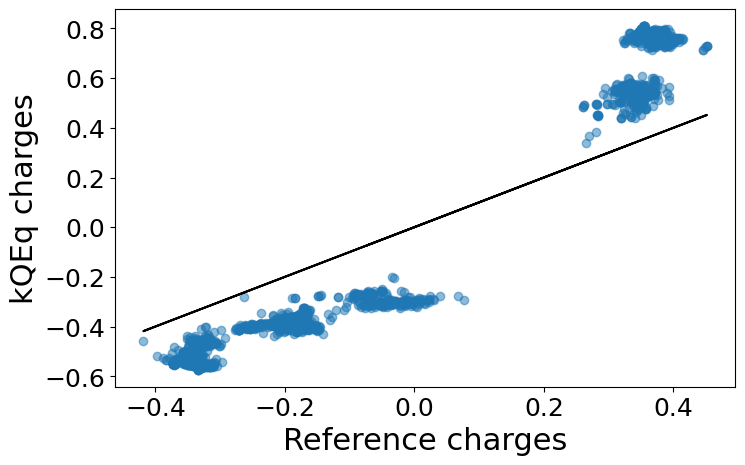

In [74]:

ref_q_test = get_charges(test_set,charge_keyword = "hirshfeld")
ref_q_train = get_charges(train_set,charge_keyword = "hirshfeld")
plot_basics(ref_en_train,E_train,preset="energy",save="trainE.png")
plot_basics(ref_q_train,q_train,preset="charges",save="trainq.png")
# view(train_set)

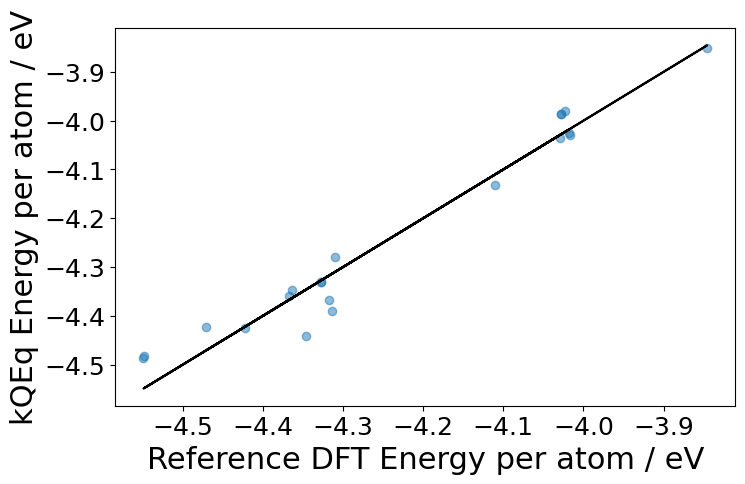

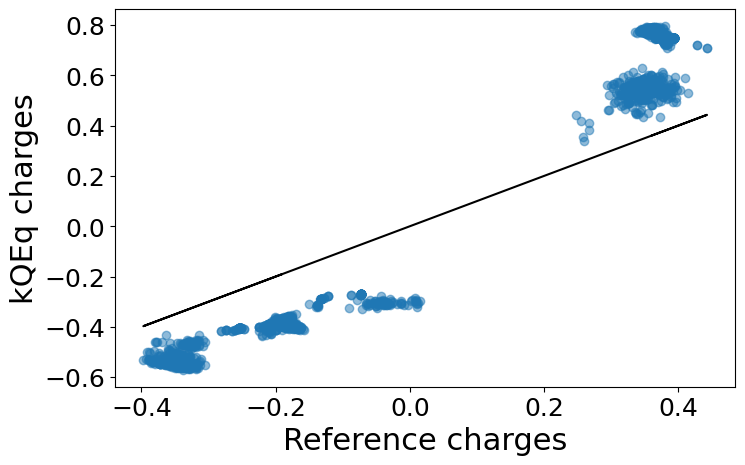

In [75]:
E_test = []
q_test = []
for a in test_set:
    res = my_kqeq.calculateEQ(a)
    E_test.append(res["energy"]/len(a))
    q_test.extend(res["charges"])
ref_en_test = get_energies_perAtom(mols=test_set,atom_energy = atom_energy)
ref_q_test = get_charges(test_set,charge_keyword = "hirshfeld")


ref_q_test = get_charges(test_set,charge_keyword = "hirshfeld")
ref_q_train = get_charges(train_set,charge_keyword = "hirshfeld")
plot_basics(ref_en_test,E_test,preset="energy",save="trainE.png")
plot_basics(ref_q_test,q_test,preset="charges",save="trainq.png")
# view(train_set)

In [76]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(ref_en_test, E_test, squared=False)
print(rms)

0.042061641828038614
